### Question 1: Autoencoder Intro (2)

In 150 words or less, describe the "nonlinear dimensionality reduction" property of autoencoders. Does this make them more or less expressive than PCA?

Autoencoders use non-linear activation functions to map input data to a lower-dimensional feature space, enabling them to capture complex, non-linear relationships that linear methods like PCA cannot. Through their encoder network, they progressively reduce data dimensions until reaching a bottleneck layer. At this bottleneck, the model encodes essential information about the input into a compressed, latent representation. This compression is therefore “nonlinear dimensionality reduction,” because it’s not limited to projecting data along straight axes. Autoencoders are generally more expressive than PCA: while PCA relies on orthogonal linear transformations, autoencoders can learn intricate, data-specific transformations.

### Question 2: Autoencoding Handwritten Digits (3)

In this question, we revisit the neural network code from the Backpropagation lesson, and rework it to become an autoencoder!

In [ ]:
%pip install jax[cpu]
%pip install optax

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import optax

from sklearn import datasets
from matplotlib import pyplot as plt

In [ ]:
digits = datasets.load_digits()
x_data, y_data = digits['data'], digits['target']

x_data = x_data / 16 # from 0 to 16, to 0 to 1 range

Let's visualize one of the data points in this dataset:

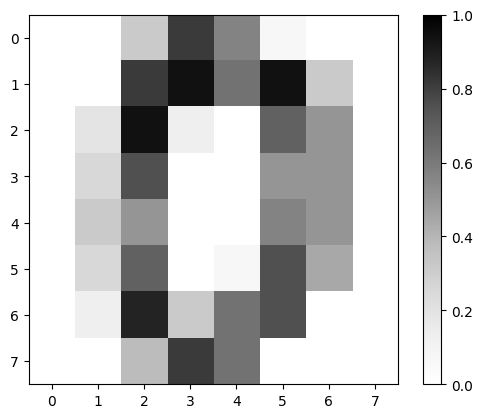

In [ ]:
plt.imshow(x_data[0].reshape(8, 8), cmap="Greys", vmin=0, vmax=1)
plt.colorbar()
plt.show()

Now, we set up the autoencoder: it's just another neural network, where *halfway through the network* we have a "bottleneck layer". The bottleneck is *significantly* smaller than the inputs *and* the rest of the network:

* The input is 64 dimensional
* The hidden layers are 8 dimensional
* The bottleneck is only 2 dimensional. That is, *all* subsequent layers past the bottleneck will only receive whatever information is "compressed" into this 2D bottleneck.

In [19]:
input_dim = 64
hidden_dim = 8
bottleneck_dim = 2
output_dim = input_dim

params = {
    "layer_1": {
        "W": np.random.normal(size=(input_dim, hidden_dim)) / np.sqrt(input_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_2": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_3": {
        "W": np.random.normal(size=(hidden_dim, bottleneck_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(bottleneck_dim,)),
    },
    "layer_4": {
    "W": np.random.normal(size=(bottleneck_dim, hidden_dim)) / np.sqrt(bottleneck_dim),
    "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_5": {
        "W": np.random.normal(size=(hidden_dim, output_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(output_dim,)),
    },
}

# Pay close attention to this function for the next question.
def predict_fn(params, X):
    X0 = X
    # remember, * is an elementwise multiply, whereas @ is a matrix multiply.
    X1 = jax.nn.relu(X0 @ params["layer_1"]["W"] + params["layer_1"]["b"])
    X2 = jax.nn.relu(X1 @ params["layer_2"]["W"] + params["layer_2"]["b"])
    X3 = X2 @ params["layer_3"]["W"] + params["layer_3"]["b"]
    X4 = jax.nn.relu(X3 @ params["layer_4"]["W"] + params["layer_4"]["b"])
    X5 = jax.nn.sigmoid(X4 @ params["layer_5"]["W"] + params["layer_5"]["b"])
    return {'reconstruct': X5, 'bottleneck': X3}

def loss_fn(params, X):
    reconstruct_X = predict_fn(params, X)['reconstruct']
    loss = -(X * jnp.log(reconstruct_X) + (1 - X) * jnp.log(1 - reconstruct_X))
    return jnp.mean(loss)

**Questions 2a**: Answer the following
* How many layers does this network have?
* Which layer is the "bottleneck layer"?
* How many layers does the encoder (the layers before bottleneck) and the decoder (the layers after the bottleneck) have?
* Why are they called "encoder" and "decoder"?
* Why are we returning `{'reconstruct': X5, 'bottleneck': X3}`? Why are these two values special?

### Answers


*   The network has 5 layers as seen in params.
*   X3: The third layer is the bottleneck layer.
*   There are 2 layers before and 3 layers after the bottleneck layer. Three of them have the same dimension (two before and two after). However, the last layer/output layer has diffe3rent dimention, equal to the input dimension (as we are regenerating it).
*  It's called encoder as we are reducing the dimension and decoder as we are reconstructing the data from the encoded data/model.
* This is important as we want to get the final layer (output layer) from the bottleneck (or the encoded model) which typically has lower dimensions. The output will be a regenerated image.




Now, let's train this model!

In [20]:
step_size = 0.01
total_steps = 3000

# We use an optimizer called Adam here.
# We won't go into detail, but think of it as "fast gradient descent"
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

grad_loss_fn = jax.grad(loss_fn)
grad_loss_fn = jax.jit(grad_loss_fn)

for i in range(total_steps):
    idxs = np.random.randint(low=0, high=x_data.shape[0], size=32)
    x_batch = x_data[idxs]
    # Remember, we compute gradients of the *first* argument, which is params.
    grad = grad_loss_fn(params, x_batch)
    update, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, update)

    # We print the loss every 100 steps
    if i % 100 == 0:
        loss_val = loss_fn(params, x_data)
        print("Step:", i, "Loss:", loss_val)

Step: 0 Loss: 0.70212966
Step: 100 Loss: 0.6064171
Step: 200 Loss: 0.45080137
Step: 300 Loss: 0.4235433
Step: 400 Loss: 0.41943192
Step: 500 Loss: 0.4173019
Step: 600 Loss: 0.4150202
Step: 700 Loss: 0.41241425
Step: 800 Loss: 0.40824926
Step: 900 Loss: 0.40393904
Step: 1000 Loss: 0.40005445
Step: 1100 Loss: 0.39681244
Step: 1200 Loss: 0.39448127
Step: 1300 Loss: 0.39288798
Step: 1400 Loss: 0.39161578
Step: 1500 Loss: 0.39078188
Step: 1600 Loss: 0.39018103
Step: 1700 Loss: 0.38921338
Step: 1800 Loss: 0.38870734
Step: 1900 Loss: 0.38790768
Step: 2000 Loss: 0.38718325
Step: 2100 Loss: 0.38661194
Step: 2200 Loss: 0.38601923
Step: 2300 Loss: 0.3853139
Step: 2400 Loss: 0.38472658
Step: 2500 Loss: 0.3840858
Step: 2600 Loss: 0.38356817
Step: 2700 Loss: 0.38288763
Step: 2800 Loss: 0.3823175
Step: 2900 Loss: 0.38200414


*Weirdly, we do not decrease the loss function significantly.*

Now, this network has two outputs: `reconstruct`, which is an attempt at reconstructing the original input, and `bottleneck`, which is the output of the bottleneck layer itself. Let's see the reconstruction vs the original:

In [ ]:
predict_vals = predict_fn(params, x_data)

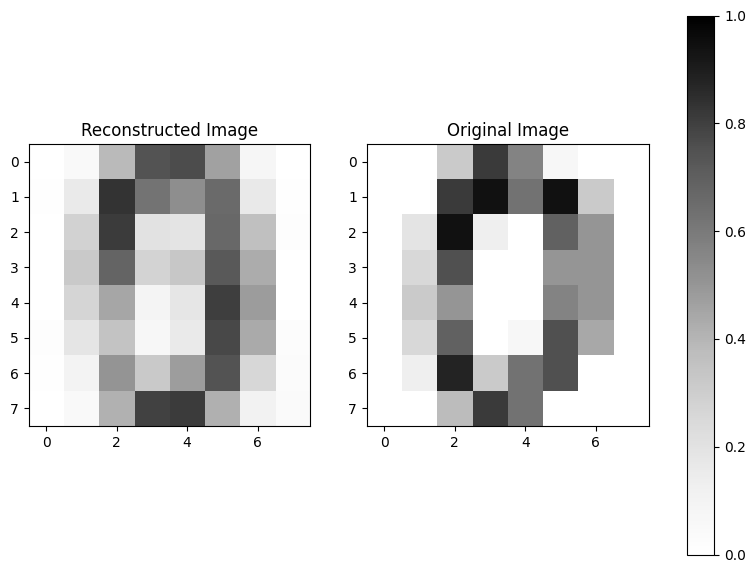

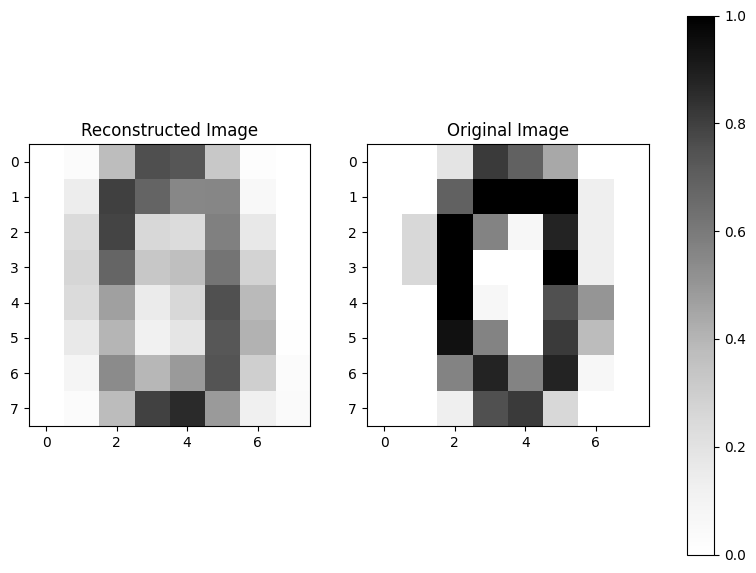

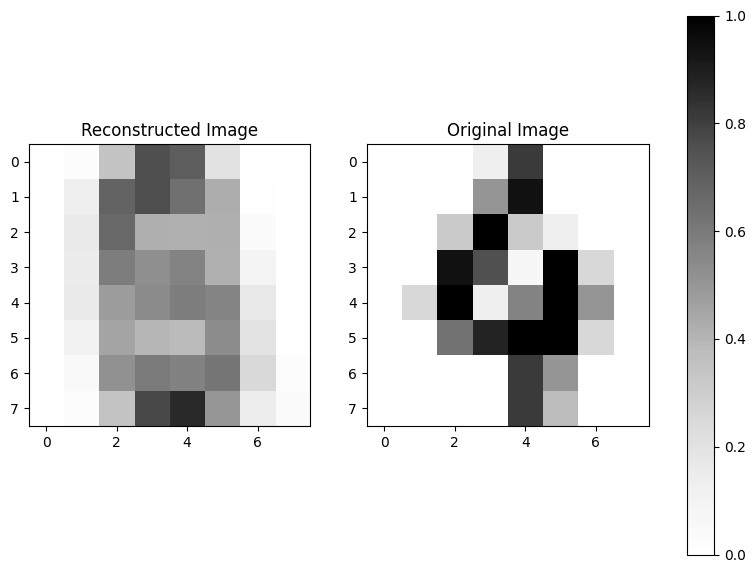

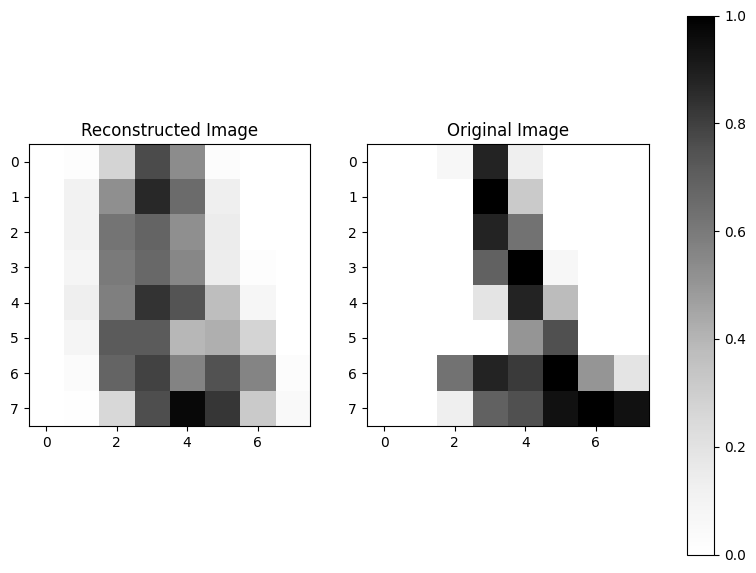

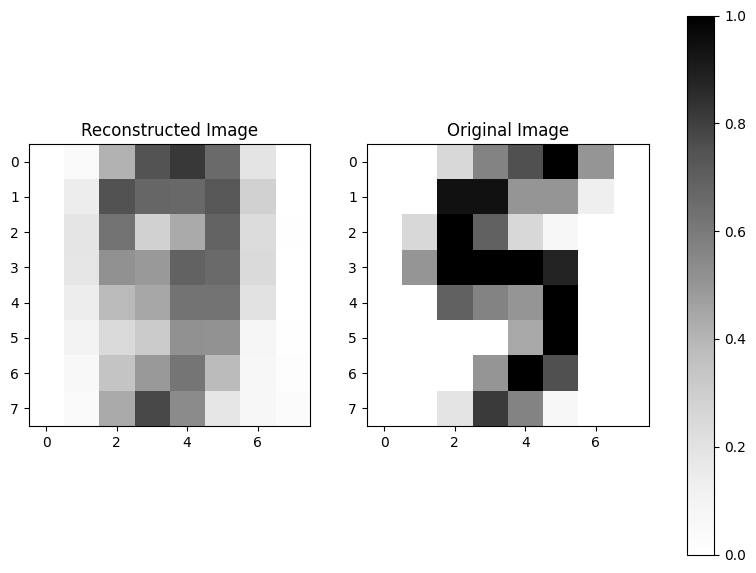

In [13]:
# Choosing a set of numbers in the range
EXAMPLE_NUMBERS = [0,20,100,1000,1700]
for EXAMPLE_NUMBER in EXAMPLE_NUMBERS:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

    img0 = ax[0].imshow(predict_vals['reconstruct'][EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")
    img1 = ax[1].imshow(x_data[EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")

    ax[0].set_title("Reconstructed Image")
    ax[1].set_title("Original Image")

    fig.colorbar(img0, ax=ax)
    plt.show()

**Question 2b**: `x_data` has 1797 examples. Try  different values of `EXAMPLE_NUMBER` within that range to see how well the model reconstructs the original. Qualitatively, how good are these reconstructions, and in what ways are they flawed?

The reconstruction are only good for the examples 0 and 20 among the examples I drew. perhaps it can only generate 0 well but not other numbers? I also noticed this in my example for audio data, where training on all data just produced noisy audio but training on a single person's voice on one language generated a meaningful set of words.

We can also extract the bottleneck values. Since the layer is 2 dimensional, we can directly plot it as a scatter plot!

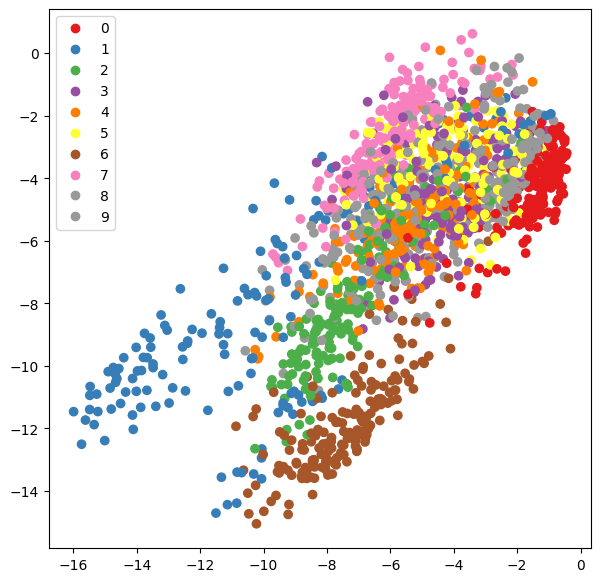

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
scatter = ax.scatter(predict_vals['bottleneck'][:, 0], predict_vals['bottleneck'][:, 1], c=y_data, cmap="Set1")
ax.legend(handles=scatter.legend_elements()[0], labels=list(digits['target_names']))
plt.show()

**Questions 2c:**

1. What behavior do you see in the plot above? Are bottleneck vectors of images of the same digit closer or further apart?
2. What can you say about this plot, given that the model *never* sees the labels during training (it purely reconstructs every digit image as provided, with no additional information about what class it belongs to)?

I changed the cmap as 0 and 1 had the same color.
Now, I see that most 0s are together. However, 1s are all over the place in the left half of the image. Maybe because of the use of the vertical line in it. Even the number 2 is overlapping with 4. But also, unlike PCW, encoders do not have highest variance in the first component but they have equal variance across all components in bottleneck. That might have caused this similarity?

### Question 3: A better autoencoder (4)

In the code cells below:
* Modify the code above, to extend the model's encoder and decoders from 2 layers to 3 layers each. (This means updating both the forward pass, and the weight initialization)
* Rerun training with this modified model, and record the loss you obtain. Is it better than in question 2?

You may copy any of the code from the cells above as needed, and modify them.

In [17]:
# Adding one layer each for encoder and decoder
input_dim = 64
hidden_dim = 8
bottleneck_dim = 2
output_dim = input_dim

params = {
    "layer_1": {
        "W": np.random.normal(size=(input_dim, hidden_dim)) / np.sqrt(input_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_2": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_3": {
        "W": np.random.normal(size=(hidden_dim, bottleneck_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(bottleneck_dim,)),
    },
    # Decoder now has three layers
    "layer_4": {
        "W": np.random.normal(size=(bottleneck_dim, hidden_dim)) / np.sqrt(bottleneck_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_5": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_6": {
        "W": np.random.normal(size=(hidden_dim, output_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(output_dim,)),
    },
}

def predict_fn(params, X):
    # Encoder
    X1 = jax.nn.relu(X @ params["layer_1"]["W"] + params["layer_1"]["b"])
    X2 = jax.nn.relu(X1 @ params["layer_2"]["W"] + params["layer_2"]["b"])
    X3 = X2 @ params["layer_3"]["W"] + params["layer_3"]["b"]  # Bottleneck

    # Decoder: three layers, with ReLU on first two, sigmoid on the last
    X4 = jax.nn.relu(X3 @ params["layer_4"]["W"] + params["layer_4"]["b"])
    X5 = jax.nn.relu(X4 @ params["layer_5"]["W"] + params["layer_5"]["b"])
    X6 = jax.nn.sigmoid(X5 @ params["layer_6"]["W"] + params["layer_6"]["b"])

    return {"reconstruct": X6, "bottleneck": X3}

def loss_fn(params, X):
    preds = predict_fn(params, X)
    reconstruct_X = preds["reconstruct"]
    loss = -(X * jnp.log(reconstruct_X) + (1 - X) * jnp.log(1 - reconstruct_X))
    return jnp.mean(loss)

## Training the model

In [18]:
step_size = 0.01
total_steps = 3000

# We use an optimizer called Adam here.
# We won't go into detail, but think of it as "fast gradient descent"
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

grad_loss_fn = jax.grad(loss_fn)
grad_loss_fn = jax.jit(grad_loss_fn)

for i in range(total_steps):
    idxs = np.random.randint(low=0, high=x_data.shape[0], size=32)
    x_batch = x_data[idxs]
    # Remember, we compute gradients of the *first* argument, which is params.
    grad = grad_loss_fn(params, x_batch)
    update, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, update)

    # We print the loss every 100 steps
    if i % 100 == 0:
        loss_val = loss_fn(params, x_data)
        print("Step:", i, "Loss:", loss_val)

Step: 0 Loss: 0.6929524
Step: 100 Loss: 0.60198206
Step: 200 Loss: 0.45712638
Step: 300 Loss: 0.4155727
Step: 400 Loss: 0.40860212
Step: 500 Loss: 0.40575156
Step: 600 Loss: 0.40375277
Step: 700 Loss: 0.40199363
Step: 800 Loss: 0.4006619
Step: 900 Loss: 0.39936748
Step: 1000 Loss: 0.3980252
Step: 1100 Loss: 0.396948
Step: 1200 Loss: 0.395783
Step: 1300 Loss: 0.39481515
Step: 1400 Loss: 0.39371684
Step: 1500 Loss: 0.39277568
Step: 1600 Loss: 0.39207554
Step: 1700 Loss: 0.39098212
Step: 1800 Loss: 0.3901285
Step: 1900 Loss: 0.38958445
Step: 2000 Loss: 0.3887172
Step: 2100 Loss: 0.38807106
Step: 2200 Loss: 0.38724494
Step: 2300 Loss: 0.38657784
Step: 2400 Loss: 0.38591215
Step: 2500 Loss: 0.38531864
Step: 2600 Loss: 0.38466352
Step: 2700 Loss: 0.3840409
Step: 2800 Loss: 0.3833319
Step: 2900 Loss: 0.38274738


It started with a much higher (almost double) loss but evetually came to the same output as double layered network. So, it did not decrease the loss, but the rate of change in loss was higher here.

# Seeing the same examples as above

In [21]:
predict_vals = predict_fn(params, x_data)

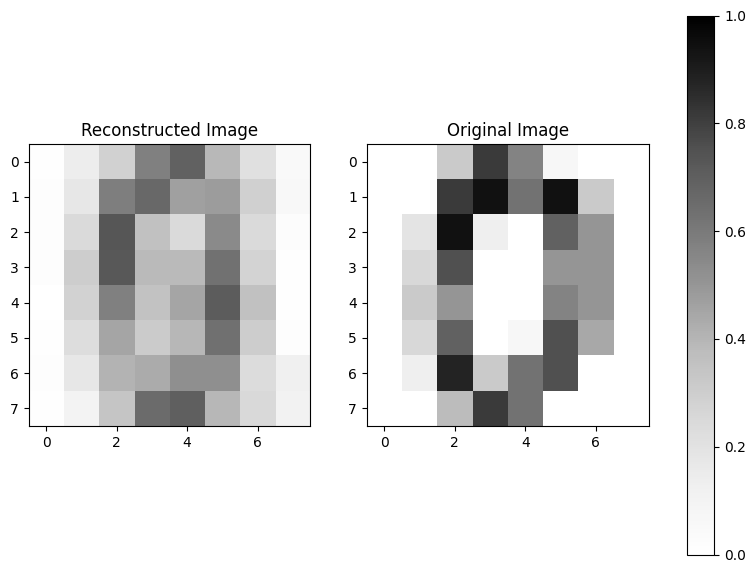

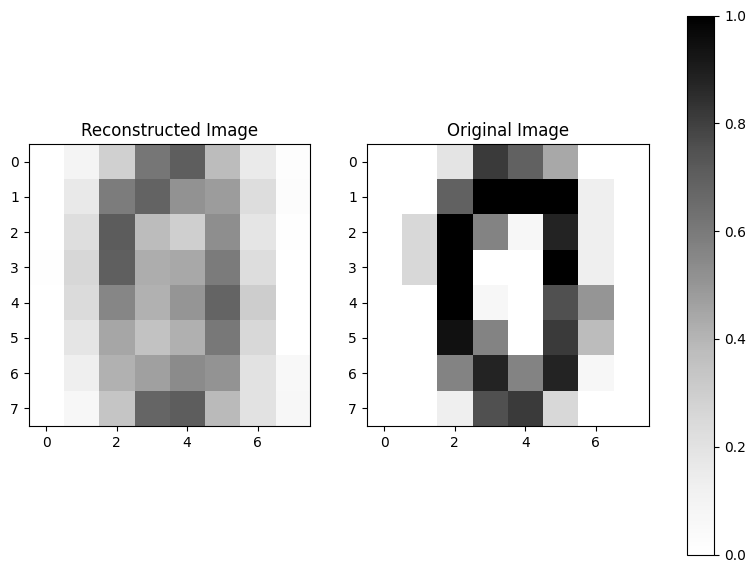

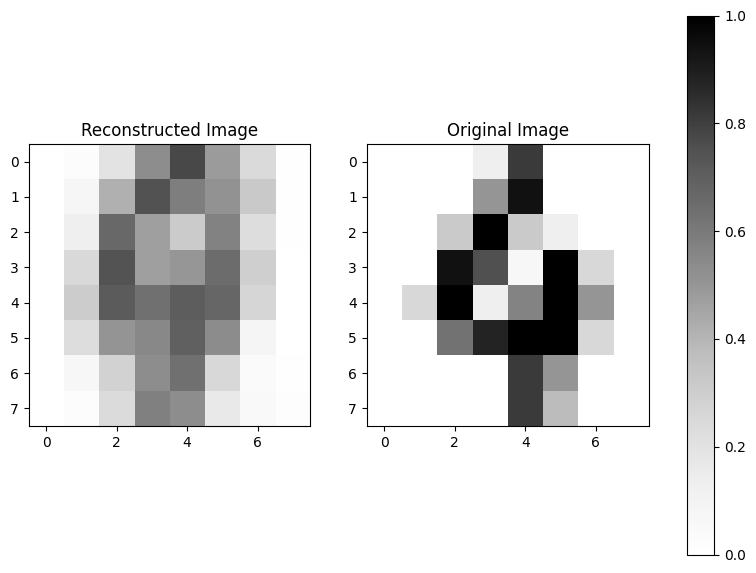

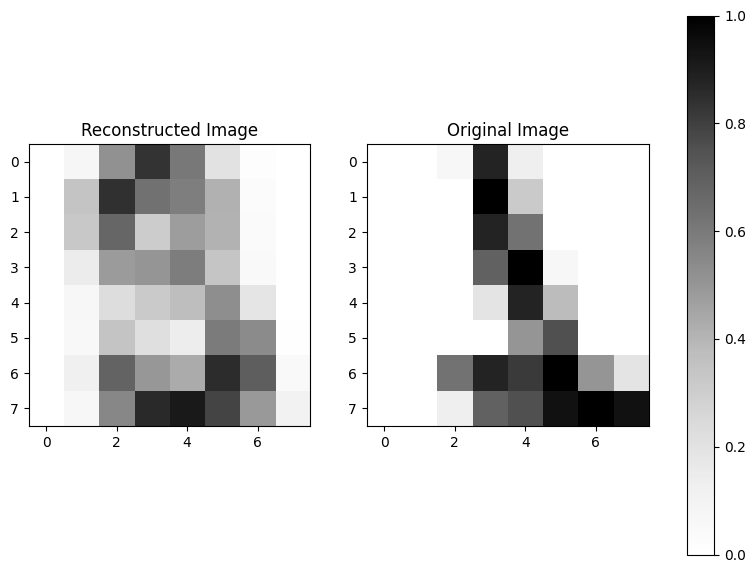

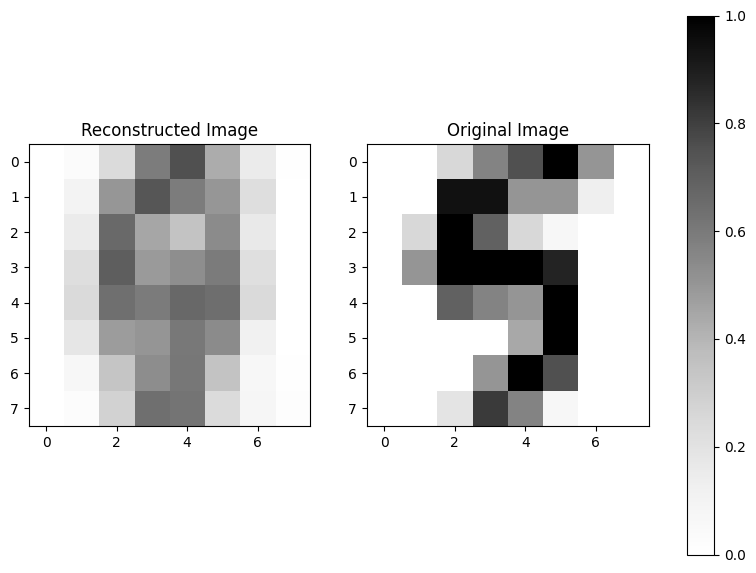

In [22]:
# Choosing a set of numbers in the range
EXAMPLE_NUMBERS = [0,20,100,1000,1700]
for EXAMPLE_NUMBER in EXAMPLE_NUMBERS:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

    img0 = ax[0].imshow(predict_vals['reconstruct'][EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")
    img1 = ax[1].imshow(x_data[EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")

    ax[0].set_title("Reconstructed Image")
    ax[1].set_title("Original Image")

    fig.colorbar(img0, ax=ax)
    plt.show()

The reconstructed images seem much better here. I'll next try a model with 5 layers in encoder and 5 layers in decoder.

In [23]:
input_dim = 64
hidden_dim = 8
bottleneck_dim = 2
output_dim = input_dim

params = {
    # Encoder layers (1–5)
    "layer_1": {
        "W": np.random.normal(size=(input_dim, hidden_dim)) / np.sqrt(input_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_2": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_3": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_4": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_5": {
        "W": np.random.normal(size=(hidden_dim, bottleneck_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(bottleneck_dim,)),
    },
    # Decoder layers (6–10)
    "layer_6": {
        "W": np.random.normal(size=(bottleneck_dim, hidden_dim)) / np.sqrt(bottleneck_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_7": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_8": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_9": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_10": {
        "W": np.random.normal(size=(hidden_dim, output_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(output_dim,)),
    },
}

def predict_fn(params, X):
    # Encoder: five layers
    X1 = jax.nn.relu(X @ params["layer_1"]["W"] + params["layer_1"]["b"])
    X2 = jax.nn.relu(X1 @ params["layer_2"]["W"] + params["layer_2"]["b"])
    X3 = jax.nn.relu(X2 @ params["layer_3"]["W"] + params["layer_3"]["b"])
    X4 = jax.nn.relu(X3 @ params["layer_4"]["W"] + params["layer_4"]["b"])
    X5 = X4 @ params["layer_5"]["W"] + params["layer_5"]["b"]  # bottleneck

    # Decoder: five layers
    X6 = jax.nn.relu(X5 @ params["layer_6"]["W"] + params["layer_6"]["b"])
    X7 = jax.nn.relu(X6 @ params["layer_7"]["W"] + params["layer_7"]["b"])
    X8 = jax.nn.relu(X7 @ params["layer_8"]["W"] + params["layer_8"]["b"])
    X9 = jax.nn.relu(X8 @ params["layer_9"]["W"] + params["layer_9"]["b"])
    X10 = jax.nn.sigmoid(X9 @ params["layer_10"]["W"] + params["layer_10"]["b"])

    return {"reconstruct": X10, "bottleneck": X5}

def loss_fn(params, X):
    preds = predict_fn(params, X)
    reconstruct_X = preds["reconstruct"]
    loss = -(X * jnp.log(reconstruct_X) + (1 - X) * jnp.log(1 - reconstruct_X))
    return jnp.mean(loss)

## Training

In [24]:
step_size = 0.01
total_steps = 3000

# We use an optimizer called Adam here.
# We won't go into detail, but think of it as "fast gradient descent"
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

grad_loss_fn = jax.grad(loss_fn)
grad_loss_fn = jax.jit(grad_loss_fn)

for i in range(total_steps):
    idxs = np.random.randint(low=0, high=x_data.shape[0], size=32)
    x_batch = x_data[idxs]
    # Remember, we compute gradients of the *first* argument, which is params.
    grad = grad_loss_fn(params, x_batch)
    update, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, update)

    # We print the loss every 100 steps
    if i % 100 == 0:
        loss_val = loss_fn(params, x_data)
        print("Step:", i, "Loss:", loss_val)

Step: 0 Loss: 0.69272774
Step: 100 Loss: 0.563437
Step: 200 Loss: 0.45994854
Step: 300 Loss: 0.4191278
Step: 400 Loss: 0.4073053
Step: 500 Loss: 0.40160254
Step: 600 Loss: 0.39795732
Step: 700 Loss: 0.39561436
Step: 800 Loss: 0.39386848
Step: 900 Loss: 0.39255005
Step: 1000 Loss: 0.39155507
Step: 1100 Loss: 0.39059553
Step: 1200 Loss: 0.3900214
Step: 1300 Loss: 0.38917878
Step: 1400 Loss: 0.38839257
Step: 1500 Loss: 0.38785097
Step: 1600 Loss: 0.38719913
Step: 1700 Loss: 0.38673228
Step: 1800 Loss: 0.3863966
Step: 1900 Loss: 0.3854554
Step: 2000 Loss: 0.3848729
Step: 2100 Loss: 0.38507366
Step: 2200 Loss: 0.38414115
Step: 2300 Loss: 0.3833241
Step: 2400 Loss: 0.38272646
Step: 2500 Loss: 0.38248
Step: 2600 Loss: 0.38176277
Step: 2700 Loss: 0.3818244
Step: 2800 Loss: 0.3808164
Step: 2900 Loss: 0.38052258


Weirdly the loss is still the same after 2900 steps. Perhaps the solution is to reduce the learbning rate and increasing the total steps. Will try that in next code cell.

After steps 5200, when the loss reached 0.3645563, the loss was nan. Weird to me. I was hoping the loss would get close to the 0 mark.

In [27]:
step_size = 0.001 # Reduced by 10 times
total_steps = 30000 # Increased by 10 times

# We use an optimizer called Adam here.
# We won't go into detail, but think of it as "fast gradient descent"
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

grad_loss_fn = jax.grad(loss_fn)
grad_loss_fn = jax.jit(grad_loss_fn)

for i in range(total_steps):
    idxs = np.random.randint(low=0, high=x_data.shape[0], size=32)
    x_batch = x_data[idxs]
    # Remember, we compute gradients of the *first* argument, which is params.
    grad = grad_loss_fn(params, x_batch)
    update, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, update)

    # We print the loss every 100 steps
    if i % 100 == 0:
        loss_val = loss_fn(params, x_data)
        print("Step:", i, "Loss:", loss_val)

Step: 0 Loss: 0.38033614
Step: 100 Loss: 0.37973768
Step: 200 Loss: 0.37914437
Step: 300 Loss: 0.37870276
Step: 400 Loss: 0.3783471
Step: 500 Loss: 0.37796822
Step: 600 Loss: 0.37759134
Step: 700 Loss: 0.3771363
Step: 800 Loss: 0.37689412
Step: 900 Loss: 0.37669474
Step: 1000 Loss: 0.37643367
Step: 1100 Loss: 0.37611794
Step: 1200 Loss: 0.37594596
Step: 1300 Loss: 0.37568876
Step: 1400 Loss: 0.37539133
Step: 1500 Loss: 0.37517554
Step: 1600 Loss: 0.3748835
Step: 1700 Loss: 0.37461895
Step: 1800 Loss: 0.37455
Step: 1900 Loss: 0.37424782
Step: 2000 Loss: 0.37403467
Step: 2100 Loss: 0.3738421
Step: 2200 Loss: 0.37393263
Step: 2300 Loss: 0.3735789
Step: 2400 Loss: 0.373322
Step: 2500 Loss: 0.3732567
Step: 2600 Loss: 0.37294412
Step: 2700 Loss: 0.3727936
Step: 2800 Loss: 0.3726687
Step: 2900 Loss: 0.3724989
Step: 3000 Loss: 0.37228835
Step: 3100 Loss: 0.37222812
Step: 3200 Loss: 0.37198785
Step: 3300 Loss: 0.3718327
Step: 3400 Loss: 0.37172967
Step: 3500 Loss: 0.37151384
Step: 3600 Loss: 0.

KeyboardInterrupt: 

## Vizualization

In [28]:
predict_vals = predict_fn(params, x_data)

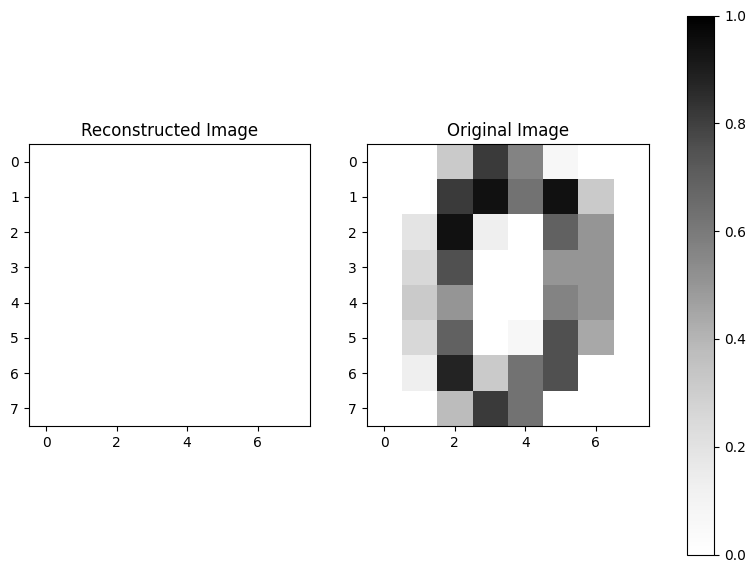

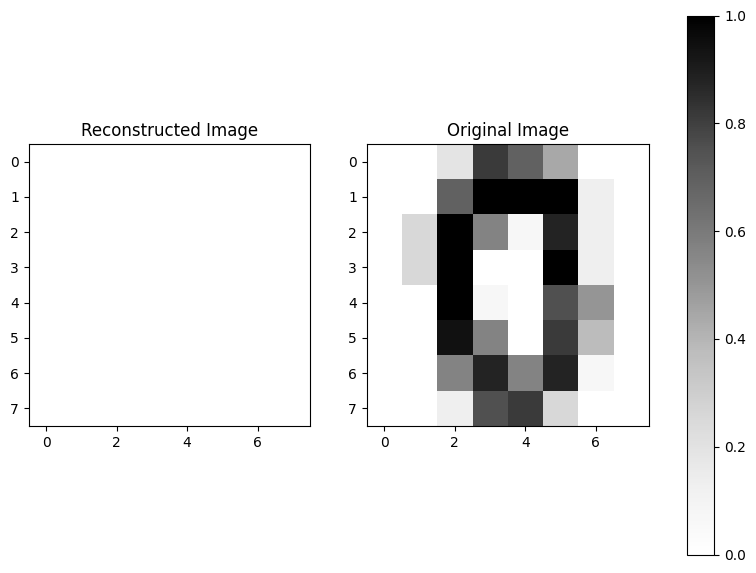

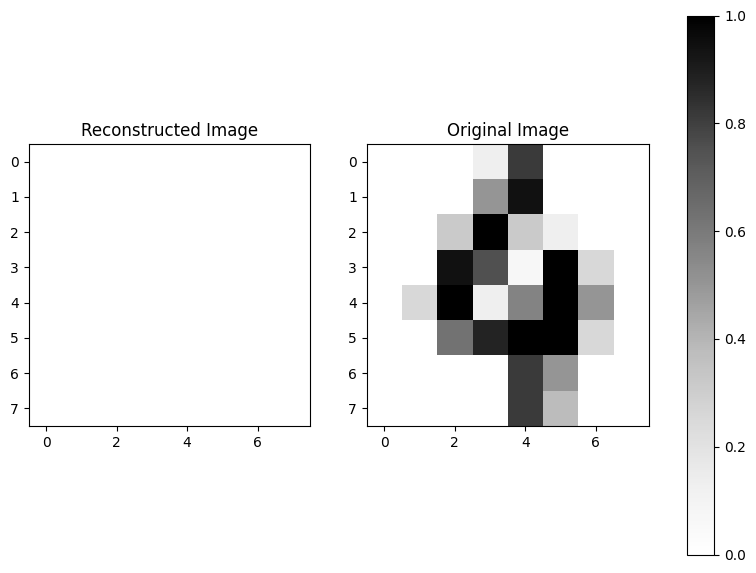

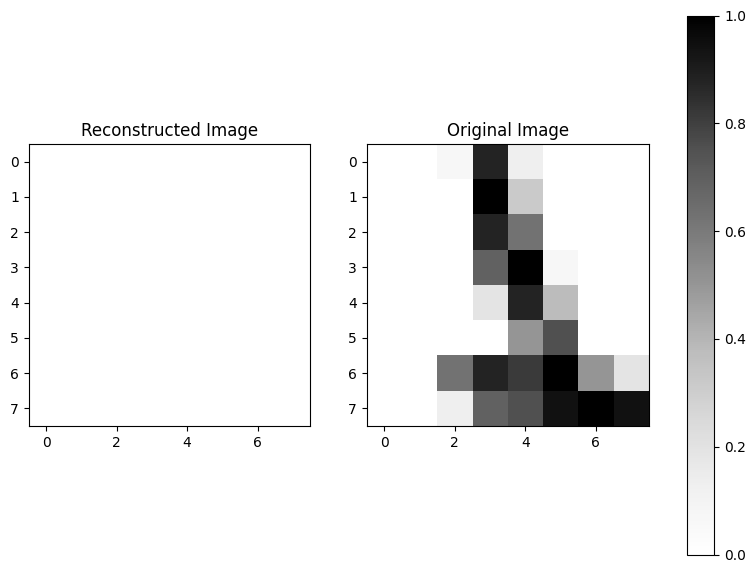

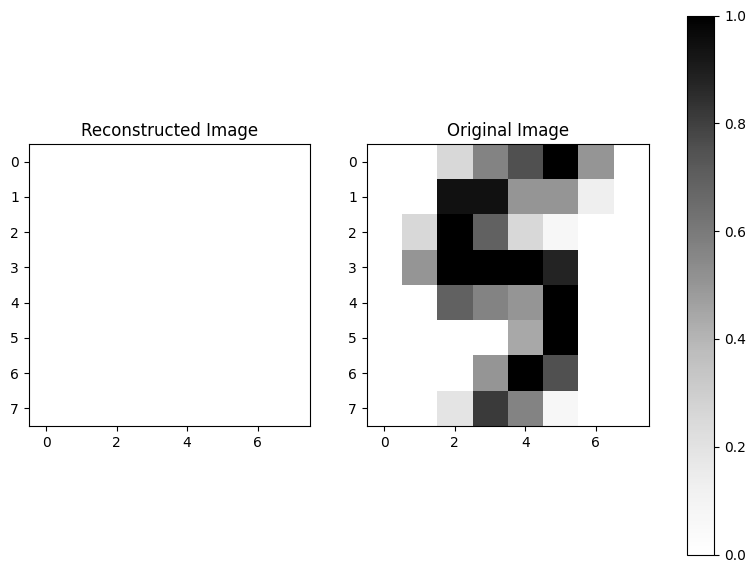

In [29]:
# Choosing a set of numbers in the range
EXAMPLE_NUMBERS = [0,20,100,1000,1700]
for EXAMPLE_NUMBER in EXAMPLE_NUMBERS:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

    img0 = ax[0].imshow(predict_vals['reconstruct'][EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")
    img1 = ax[1].imshow(x_data[EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")

    ax[0].set_title("Reconstructed Image")
    ax[1].set_title("Original Image")

    fig.colorbar(img0, ax=ax)
    plt.show()